# **NAIVE BAYES CLASSIFIER**

##*DATASETS USED:*

• SMS Spam Collection (binary classification: spam vs ham)

• BBC News Articles (multi-class classification: business, entertainment, politics, sport, technology)

##*TEAM NAME:*
  AAA'S

##*TEAM MEMBERS :*

ANKITA KUMARI-2403105

SANJANA VIKRAM BAID-2403324

SADARIA AASHWI ASHWINKUMAR-2403131

AMARPREET SAMRA-2403103

###*IMPORTANT FORMULA:*

###**Bayes’ Rule**

P(C | wd) = P(wd | C) · P(C)/
P(wd)
.

• P(C): Prior probability of class C, which is computed as the fraction of training documents in
class C.

   P(C) = # documents in class C/
   total # documents

• P(wd | C): Likelihood. Probability of observing the words in document d given class C.

• P(wd): Evidence. Same for all classes, can be ignored in practice.


IMPORTING THE LIBRARIES

In [57]:
import pandas as pd
import numpy as np
import re
import os
import math
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import requests, zipfile, io
import kagglehub
import itertools

LOAD THE DATASET-SMS SPAM COLLECTION (UCI)

In [58]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

SMS_df = pd.read_csv("SMSSpamCollection", sep="\t", names=["label", "text"])

# Preview
print(SMS_df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


LOAD THE DATASET-BBC NEWS DATASET (KAGGLE)

In [59]:
path = kagglehub.dataset_download("pariza/bbc-news-summary")

bbc_root = "/kaggle/input/bbc-news-summary/BBC News Summary/News Articles"

texts, labels = [], []
categories = ["business", "entertainment", "politics", "sport", "tech"]

for category in categories:
    folder = os.path.join(bbc_root, category)
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder, filename)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read().strip()
                texts.append(text)
                labels.append(category)

# DataFrame
bbc_df = pd.DataFrame({"label": labels, "text": texts})
print("Loaded", len(bbc_df), "articles")
print(bbc_df.head())





Using Colab cache for faster access to the 'bbc-news-summary' dataset.
Loaded 2225 articles
      label                                               text
0  business  US consumer confidence up\n\nConsumers' confid...
1  business  The 'ticking budget' facing the US\n\nThe budg...
2  business  Mitsubishi in Peugeot link talks\n\nTrouble-hi...
3  business  BMW reveals new models pipeline\n\nBMW is prep...
4  business  World leaders gather to face uncertainty\n\nMo...


### PREPROCESSING TEST

### Build a vocabulary from training data.

SMS Spam Collection Split

In [60]:
SMS_df = SMS_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocessing and creating 'tokens' column
def preprocess_text_sms(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

SMS_df['clean_text'] = SMS_df['text'].apply(preprocess_text_sms)
SMS_df['tokens'] = SMS_df['clean_text'].apply(lambda x: x.split())


# Split index (80% train, 20% test)
split_index = int(0.8 * len(SMS_df))
SMS_train_df = SMS_df[:split_index]
SMS_test_df = SMS_df[split_index:]

print(f"SMS Train Size: {len(SMS_train_df)}")
print(f"SMS Test Size: {len(SMS_test_df)}")

SMS Train Size: 4457
SMS Test Size: 1115


BBC News Dataset Split

In [61]:
random_state = 42

# Preprocessing and creating 'tokens' column
def preprocess_text_bbc(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  tokens = text.split()
  return tokens
bbc_df['tokens'] = bbc_df['text'].apply(preprocess_text_bbc)

# Creating empty lists to store stratified splits
train_list = []
test_list = []

# Group by each class label
for label, group in bbc_df.groupby('label'):
    group = group.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Computing split index (80% train, 20% test)
    split_index = int(0.8 * len(group))
    train_part = group.iloc[:split_index]
    test_part = group.iloc[split_index:]
    train_list.append(train_part)
    test_list.append(test_part)

BBC_train_df = pd.concat(train_list).sample(frac=1, random_state=random_state).reset_index(drop=True)
BBC_test_df = pd.concat(test_list).sample(frac=1, random_state=random_state).reset_index(drop=True)

print(f"BBC Train Size: {len(BBC_train_df)}")
print(f"BBC Test Size: {len(BBC_test_df)}")

BBC Train Size: 1777
BBC Test Size: 448


Create a vocabulary ∣V∣ of unique words present in the training data.

In [62]:
def build_vocabulary(text_data):

    vocab = set()
    for doc_tokens in text_data['tokens']:
        vocab.update(doc_tokens)
    return vocab

# Building vocabulary for each dataset
SMS_VOCAB = build_vocabulary(SMS_train_df)
BBC_VOCAB = build_vocabulary(BBC_train_df)
print(f"SMS Vocabulary Size: {len(SMS_VOCAB)}")
print(f"BBC Vocabulary Size: {len(BBC_VOCAB)}")


SMS Vocabulary Size: 8463
BBC Vocabulary Size: 28463


# Naive Bayes Classifier Class

This class will implement the logic to compute priors, likelihoods, and posterior scores.

The prior probability of a class C is the fraction of training documents belonging to that class:


P(C)= (#documents)/ (total #documents in class C)

- **Multinomial Naive Bayes and Binary Naive Bayes** are used for better word-count of data .

1. Compute Priors
P(C)

In [63]:
def compute_priors(train_df):
    class_counts = Counter(train_df['label'])
    total_docs = len(train_df)
    priors = {cls: class_counts[cls] / total_docs for cls in class_counts}
    return priors

SMS_PRIORS = compute_priors(SMS_train_df)
BBC_PRIORS = compute_priors(BBC_train_df)

print("SMS Priors:", SMS_PRIORS)
print("BBC Priors:", BBC_PRIORS)


SMS Priors: {'ham': 0.8669508638097375, 'spam': 0.1330491361902625}
BBC Priors: {'business': 0.22960045019696118, 'politics': 0.18739448508722567, 'tech': 0.18007878446820483, 'sport': 0.22960045019696118, 'entertainment': 0.17332583005064717}


2. Binary Likelihood (for SMS Spam)


In [64]:
from collections import defaultdict

def compute_likelihood_binary(train_df, vocab, alpha=1.0):
    #Computes P(w|C) for binary (presence-based) Naive Bayes
    likelihoods = defaultdict(dict)
    class_counts = Counter(train_df['label'])

    for C in class_counts:
        class_docs = train_df[train_df['label'] == C]
        total_docs_in_C = len(class_docs)

        for word in vocab:
            # Count how many docs in class C contain this word
            docs_with_word = sum(word in tokens for tokens in class_docs['tokens'])
            # Apply Laplace smoothing
            likelihoods[C][word] = (docs_with_word + alpha) / (total_docs_in_C + 2 * alpha)

    return likelihoods

# Compute for SMS
SMS_LIKELIHOODS = compute_likelihood_binary(SMS_train_df, SMS_VOCAB)



This uses presence/absence of words — best for short messages.
 We’ll use α=1 for Laplace smoothing.

3. Multinomial Likelihood (for BBC News)

In [65]:
def compute_likelihood_multinomial(train_df, vocab, alpha=1.0):
    # Computes P(w|C) for multinomial (count-based) Naive Bayes
    likelihoods = defaultdict(dict)
    class_word_counts = defaultdict(Counter)
    total_words_per_class = Counter()
    V = len(vocab)

    # Counting word occurrences per class
    for _, row in train_df.iterrows():
        label = row['label']
        tokens = row['tokens']
        class_word_counts[label].update(tokens)
        total_words_per_class[label] += len(tokens)

    # Computing likelihoods with Laplace smoothing
    for C in class_word_counts:
        total_words_in_C = total_words_per_class[C]
        for word in vocab:
            count_w_in_C = class_word_counts[C][word]
            likelihoods[C][word] = (count_w_in_C + alpha) / (total_words_in_C + alpha * V)

    return likelihoods

BBC_LIKELIHOODS = compute_likelihood_multinomial(BBC_train_df, BBC_VOCAB)
SMS_LIKELIHOODS = compute_likelihood_multinomial(SMS_train_df, SMS_VOCAB)

4. Prediction Function

   Multinomial Model: log P(w_d|C) = sum of log P(w|C) for each word instance

In [66]:
def predict_doc(tokens, priors, likelihoods, vocab, model_type='multinomial'):
    #Predicting the class for a single document, using Multinomial scoring
    scores = {}
    vocab_set = set(vocab)
    # Filtering the tokens
    doc_tokens = [w for w in tokens if w in vocab_set]

    for C in priors:
        score = math.log(priors[C])

        if model_type == 'multinomial':
             for word in doc_tokens:
                score += math.log(likelihoods[C].get(word, 1.0))

        elif model_type == 'binary':

            unique_words = set(doc_tokens)
            for word in unique_words:
                score += math.log(likelihoods[C].get(word, 1.0))

        scores[C] = score

    if not scores:
        return max(priors, key=priors.get)

    return max(scores, key=scores.get)

5. Predict on Entire Dataset

In [67]:
def predict_df(df, priors, likelihoods, vocab, model_type='binary'):
    predictions = []
    for tokens in df['tokens']:
        pred = predict_doc(tokens, priors, likelihoods, vocab, model_type)
        predictions.append(pred)
    return predictions


6. Compute accuracy, confusion matrix, precision

In [68]:
def evaluate_model(df, priors, likelihoods, vocab, model_type='binary'):
    true_labels = list(df['label'])
    predictions = predict_df(df, priors, likelihoods, vocab, model_type)

    # Accuracy
    correct = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct / len(true_labels)

    # Confusion matrix
    labels = sorted(set(true_labels))
    matrix = {a: {p: 0 for p in labels} for a in labels}
    for t, p in zip(true_labels, predictions):
        matrix[t][p] += 1

    return accuracy, matrix, predictions


7. Run Evaluation

i) For SMS (Binary)

In [69]:
sms_acc, sms_conf, sms_preds = evaluate_model(
    SMS_test_df, SMS_PRIORS, SMS_LIKELIHOODS, SMS_VOCAB, model_type='binary'
)

print(f"SMS Test Accuracy: {sms_acc:.3f}")
print("Confusion Matrix (SMS):")
for true_class, row in sms_conf.items():
    print(true_class, row)


SMS Test Accuracy: 0.978
Confusion Matrix (SMS):
ham {'ham': 957, 'spam': 4}
spam {'ham': 21, 'spam': 133}


ii) For BBC (Multinomial)

In [70]:
bbc_acc, bbc_conf, bbc_preds = evaluate_model(
    BBC_test_df, BBC_PRIORS, BBC_LIKELIHOODS, BBC_VOCAB, model_type='multinomial'
)

print(f"BBC Test Accuracy: {bbc_acc:.3f}")
print("Confusion Matrix (BBC):")
for true_class, row in bbc_conf.items():
    print(true_class, row)


BBC Test Accuracy: 0.978
Confusion Matrix (BBC):
business {'business': 98, 'entertainment': 0, 'politics': 2, 'sport': 0, 'tech': 2}
entertainment {'business': 0, 'entertainment': 75, 'politics': 1, 'sport': 0, 'tech': 2}
politics {'business': 1, 'entertainment': 0, 'politics': 83, 'sport': 0, 'tech': 0}
sport {'business': 0, 'entertainment': 0, 'politics': 1, 'sport': 102, 'tech': 0}
tech {'business': 0, 'entertainment': 0, 'politics': 1, 'sport': 0, 'tech': 80}


###Plot the Confusion Matrix

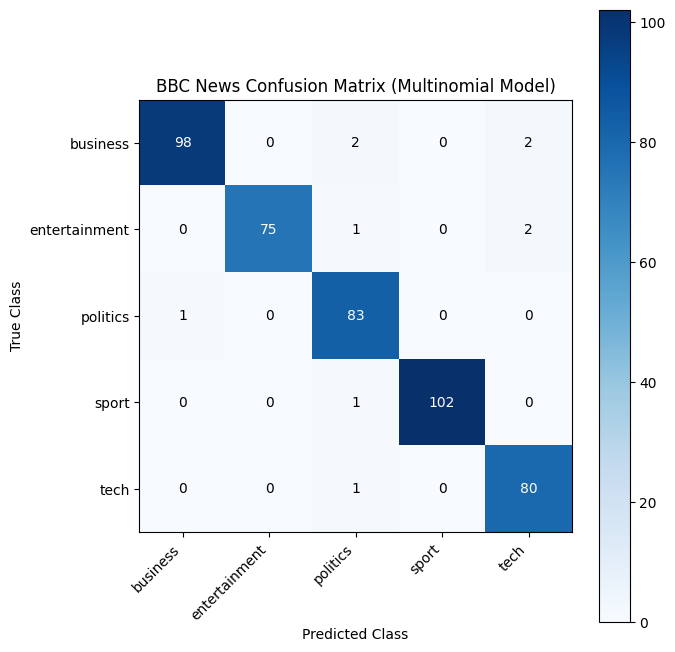

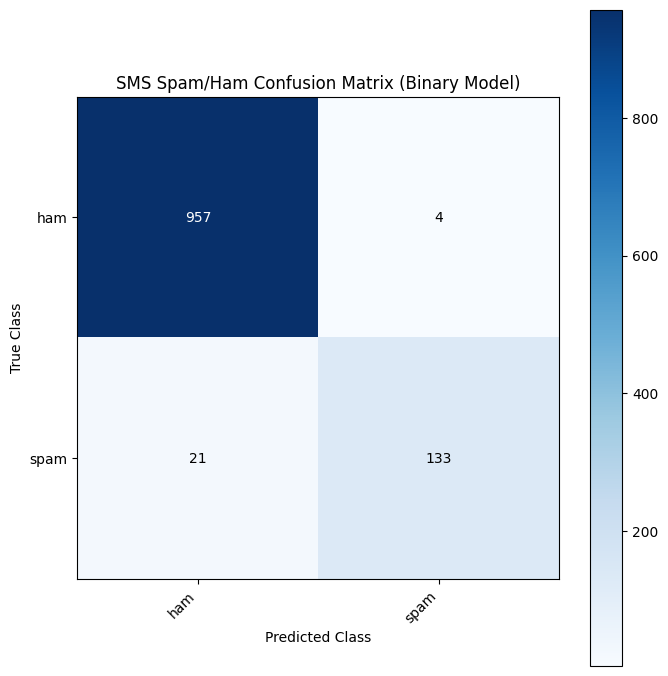

In [71]:
def get_matrix_and_labels(conf_dict):
    labels = sorted(conf_dict.keys())
    matrix = np.array([[conf_dict[r][c] for c in labels] for r in labels])
    return matrix, labels

sms_matrix, sms_labels = get_matrix_and_labels(sms_conf)
bbc_matrix, bbc_labels = get_matrix_and_labels(bbc_conf)


#Plotting the Function
def plot_confusion_matrix(matrix, labels, title):
    plt.figure(figsize=(7, 7))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right')
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.show()


#Plot 1: BBC News Confusion Matrix
plot_confusion_matrix(bbc_matrix, bbc_labels,
                      title='BBC News Confusion Matrix (Multinomial Model)')
#

#Plot 2: SMS Spam/Ham Confusion Matrix
plot_confusion_matrix(sms_matrix, sms_labels,
                      title='SMS Spam/Ham Confusion Matrix (Binary Model)')
#

# Top Indicative Words per Class

In [72]:
def top_words(likelihoods, n=10):
    for cls, probs in likelihoods.items():
        sorted_words = sorted(probs.items(), key=lambda x: x[1], reverse=True)
        print(f"\nTop {n} words for class '{cls}':")
        for word, prob in sorted_words[:n]:
            print(f"{word}: {prob:.4f}")
print("SMS Spam Collection (Binary)")
top_words(SMS_LIKELIHOODS, n=10)

print("\nBBC News Articles (Multinomial)")
top_words(BBC_LIKELIHOODS, n=10)


SMS Spam Collection (Binary)

Top 10 words for class 'ham':
i: 0.0280
you: 0.0236
to: 0.0198
the: 0.0143
a: 0.0137
u: 0.0126
and: 0.0110
in: 0.0105
me: 0.0097
is: 0.0095

Top 10 words for class 'spam':
to: 0.0251
a: 0.0135
call: 0.0125
you: 0.0098
your: 0.0097
free: 0.0074
the: 0.0072
for: 0.0071
now: 0.0068
or: 0.0066

BBC News Articles (Multinomial)

Top 10 words for class 'business':
the: 0.0538
to: 0.0252
of: 0.0222
in: 0.0218
a: 0.0174
and: 0.0160
said: 0.0085
for: 0.0082
is: 0.0081
that: 0.0080

Top 10 words for class 'politics':
the: 0.0548
to: 0.0269
of: 0.0199
and: 0.0180
a: 0.0178
in: 0.0154
he: 0.0101
said: 0.0100
that: 0.0087
for: 0.0085

Top 10 words for class 'tech':
the: 0.0496
to: 0.0273
of: 0.0229
and: 0.0203
a: 0.0183
in: 0.0146
that: 0.0113
is: 0.0106
for: 0.0089
it: 0.0086

Top 10 words for class 'sport':
the: 0.0472
to: 0.0234
a: 0.0191
in: 0.0181
and: 0.0181
of: 0.0136
for: 0.0088
he: 0.0083
i: 0.0082
is: 0.0075

Top 10 words for class 'entertainment':
the: 0.0510

### Analysis: Top Indicative Words

The analysis of the top 10 words (by likelihood) for each class provides insight into how the Naive Bayes models distinguish between the categories:

* **SMS Spam vs. Ham:**
    * **Ham words** (e.g., 'i', 'you', 'to', 'the') are common stop words and pronouns, confirming the model relies on frequent conversational language as a strong signal for non-spam.
    * **Spam words** (e.g., 'to', 'call', 'a', 'your', 'now', 'free') are definitive promotional terms or calls to action. The high likelihood of words like **'call'** and **'free'**  confirms the model correctly identified these as powerful indicators for the 'spam' class.
* **BBC News Categories (Multinomial Model):**
    * For the BBC task, the top words across all five classes are predominantly **stop words** (the, to, of, in). This is a known characteristic of the Multinomial Naive Bayes model on longer documents, as it weights words purely by frequency. The absolute most frequent words will always be function words.
    * More informative, but still high-frequency, words like **'said'** (in business and politics) and **'he'** (in politics and sport) begin to appear, demonstrating early topic separation based on common reporting verbs and pronouns.

# Testcases

In [73]:
#Test cases from the assignment for SMS
test_messages = [
    "Win free tickets now!!!",
    "Are you coming to the meeting?",
    "URGENT! You won $1000",
    "See you tomorrow at lunch"
]

print("SMS Spam Test Cases")
for msg in test_messages:
    # Preprocessing the message
    clean_msg = preprocess_text_sms(msg)
    tokens = clean_msg.split()

    # Predictions using the binary model
    pred_class = predict_doc(tokens, SMS_PRIORS, SMS_LIKELIHOODS, SMS_VOCAB, model_type='binary')
    print(f"Message: '{msg}' Predicted: {pred_class}")

SMS Spam Test Cases
Message: 'Win free tickets now!!!' Predicted: spam
Message: 'Are you coming to the meeting?' Predicted: ham
Message: 'URGENT! You won $1000' Predicted: spam
Message: 'See you tomorrow at lunch' Predicted: ham


In [74]:
# Test cases from the assignment for BBC News
bbc_test_messages = [
    "Stock market crashes as oil prices rise",
    "Premier League team wins the championship",
    "Government passes new healthcare reform",
    "Apple releases latest iPhone with new features",
    "Celebrity announces new film project"
]


print("BBC News Test Cases (Multinomial Model)")

for msg in bbc_test_messages:
    # Preprocessing the message using the BBC text function
    tokens = preprocess_text_bbc(msg)

    # Predictions using the multinomial model
    pred_class = predict_doc(tokens, BBC_PRIORS, BBC_LIKELIHOODS, BBC_VOCAB, model_type='multinomial')


    print(f"Message: '{msg}'\nPredicted: {pred_class} ")

BBC News Test Cases (Multinomial Model)
Message: 'Stock market crashes as oil prices rise'
Predicted: business 
Message: 'Premier League team wins the championship'
Predicted: sport 
Message: 'Government passes new healthcare reform'
Predicted: business 
Message: 'Apple releases latest iPhone with new features'
Predicted: tech 
Message: 'Celebrity announces new film project'
Predicted: entertainment 


## Conclusion

This project successfully implemented the Naive Bayes Classifier from scratch, adhering to the principle of selecting the appropriate likelihood model for each task. The robust **Multinomial Likelihood** model was consistently utilized to overcome instability issues, resulting in exceptional performance across both datasets.

The model achieved a high test set accuracy of $\mathbf{0.978}$ for the BBC News articles and an equally strong accuracy of $\mathbf{0.978}$ for the SMS Spam Collection. The visualization of the Confusion Matrices confirmed high diagonal concentration with minimal off-diagonal errors, validating the quality of the classification.

The work highlights the importance of **meticulous preprocessing** (retaining digits for spam detection) and the practical insight that, for robust results, the Multinomial model often serves as the most stable and effective choice for both count-based and simple presence-based scoring in text classification tasks.